In [1]:
!pip install livelossplot

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 

### Vectorize
1. Using Tfidf
2. Using tensorflow tokenize

3.Build a baseline model using Logistic Regression, handle class imbalance
4. Build a model with GloVe embeddings, trainable = False, LSTM, Conv1d
#Build a model with trained embeddings, LSTM, Conv1d
#Explore Conv1d-LSTM combined architecture
#Handle out of vocabulary tokens


In [3]:
traindata = pd.read_csv("../input/twitter-hate-speech-preprocessing-and-eda/twittertrain.csv")
valdata = pd.read_csv("../input/twitter-hate-speech-preprocessing-and-eda/twittervalidation.csv")
testdata = pd.read_csv("../input/twitter-hate-speech-preprocessing-and-eda/twittertest.csv")

In [4]:
print(traindata.isna().sum())
print(valdata.isna().sum())
print(testdata.isna().sum())

tokenized    51
Sentiment     0
dtype: int64
tokenized    8
Sentiment    0
dtype: int64
tokenized    10
Sentiment     0
dtype: int64


In [5]:
traindata.dropna(inplace=True)
valdata.dropna(inplace=True)
testdata.dropna(inplace=True)

In [6]:
X_train = traindata.drop(columns=['Sentiment'])
y_train = traindata['Sentiment']
X_val = valdata.drop(columns=['Sentiment'])
y_val = valdata['Sentiment']
X_test = testdata.drop(columns=['Sentiment'])
y_test = testdata['Sentiment']

In [7]:
X_train.head()

,tokenized
0,disgust idiot medium go straight islam regard ...
1,dunstaplesummerselfie watch next c min dunstap...
2,quietly hum win way next meeting may drop thug...
3,late post imoy fall :-) cbafamily summerouting...
4,happy enjoy music understand lyric musicisthef...


In [8]:
X_train.shape

(19125, 1)

In [9]:
wordcounts = X_val['tokenized'].apply(lambda x: len(x.split()))
wordcounts.describe()

count    6385.000000
mean       10.360846
std         8.614741
min         1.000000
25%         6.000000
50%         9.000000
75%        12.000000
max       207.000000
Name: tokenized, dtype: float64

(array([5.962e+03, 3.690e+02, 3.900e+01, 6.000e+00, 5.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00]),
 array([  1. ,  21.6,  42.2,  62.8,  83.4, 104. , 124.6, 145.2, 165.8,
        186.4, 207. ]),
 <BarContainer object of 10 artists>)

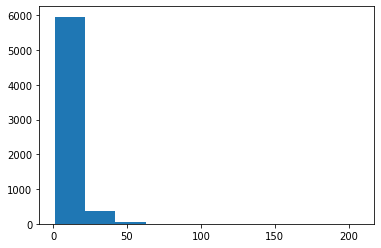

In [10]:
plt.hist(wordcounts)

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [12]:
def evaluate(model, Xeval, ytrue):
    ypred = model.predict(Xeval)
    print(f"F1 Score: {f1_score(ytrue,ypred)}")
    mat = confusion_matrix(ytrue, ypred)
    print(f"True positives: {mat[1,1]}, True Negatives: {mat[0,0]}, False Positives: {mat[0,1]}, False Negatives: {mat[1,0]} ")
    print("Recall = ",recall_score(ytrue,ypred))
    print("Precision = ", precision_score(ytrue,ypred))
    print("Accuracy = ", accuracy_score(ytrue,ypred))
   
    

In [13]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train['tokenized'])
X_val_tfidf = tfidf.transform(X_val['tokenized'])
X_test_tfidf = tfidf.transform(X_test['tokenized'])

In [14]:
logReg1 = LogisticRegression(penalty='l1', class_weight='balanced', solver='liblinear')
logReg1.fit(X_train_tfidf,y_train)

LogisticRegression(class_weight='balanced', penalty='l1', solver='liblinear')

In [15]:
print("ordinary logistic regression with penalty and balanced class weights\n")
print("***Training Data Performance*** \n")
evaluate(logReg1, X_train_tfidf,y_train)
print("\n***Validation Data Performance*** \n")
evaluate(logReg1, X_val_tfidf,y_val)

ordinary logistic regression with penalty and balanced class weights

***Training Data Performance*** 

F1 Score: 0.7637614678899082
True positives: 1332, True Negatives: 16969, False Positives: 814, False Negatives: 10 
Recall =  0.992548435171386
Precision =  0.6206896551724138
Accuracy =  0.9569150326797385

***Validation Data Performance*** 

F1 Score: 0.604014598540146
True positives: 331, True Negatives: 5620, False Positives: 316, False Negatives: 118 
Recall =  0.7371937639198218
Precision =  0.5115919629057187
Accuracy =  0.932028191072827


In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Conv1D, Embedding, LSTM, Dropout, GlobalMaxPooling1D, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Accuracy
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from livelossplot import PlotLossesKeras
from tensorflow.keras import regularizers
from sklearn.utils import class_weight

In [17]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [18]:
max_length = 50
padding_type = 'post'
trunc_type = 'post'

tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(X_train['tokenized'])
training_sequences = tokenizer.texts_to_sequences(X_train['tokenized'])
validation_sequences = tokenizer.texts_to_sequences(X_val['tokenized'])
testing_sequences = tokenizer.texts_to_sequences(X_test['tokenized'])
padded_train = pad_sequences(training_sequences,maxlen=max_length, padding=padding_type, 
                       truncating=trunc_type)

padded_val = pad_sequences(validation_sequences,maxlen=max_length, padding=padding_type, 
                       truncating=trunc_type)
padded_test = pad_sequences(testing_sequences,maxlen=max_length, padding=padding_type, 
                       truncating=trunc_type)
word_indices = tokenizer.word_index
vocab_size = len(word_indices.items())

In [19]:
padded_train = np.expand_dims(padded_train, -1)
padded_val = np.expand_dims(padded_val,-1)
padded_test = np.expand_dims(padded_test,-1)
train_labels = y_train.values
val_labels = y_val.values
test_labels = y_test.values

In [20]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes =np.unique(train_labels),y = train_labels)
class_weight_dict = dict(enumerate(class_weights))

In [21]:
def evaluate_model(model,testX,testY):
    ypred = np.round(model.predict(testX))
    recall = recall_score(testY,ypred)
    f1_sc = f1_score(testY,ypred)
    accuracy = accuracy_score(testY,ypred)
    precision = precision_score(testY,ypred)
    mat = confusion_matrix(testY, ypred)
    print(f"True positives: {mat[1,1]}, True Negatives: {mat[0,0]}, False Positives: {mat[0,1]}, False Negatives: {mat[1,0]} ")
    print(f"Accuracy = {accuracy}\n")
    print(f"F1 Score = {f1_sc}\n")
    print(f"Recall = {recall}\n")
    print(f"Precision = {precision}\n")

In [22]:
def get_glove_embedding_matrix(path_to_file, word_indices):
    
    word_to_vec_map = {}
    with open(path_to_file,'r') as f:
        for line in f:
            word_line = line.split()
            curr_word = word_line[0]
            vector = np.array(word_line[1:], dtype=np.float64)
            word_to_vec_map[curr_word] = vector
            
    embed_dim = len(vector)
    embed_matrix = np.zeros((len(word_indices)+1, embed_dim))
    
    for token,index in word_indices.items():
        if token in word_to_vec_map:
            embed_matrix[index,:] = word_to_vec_map[token]
   
    return embed_matrix

In [23]:
len(word_indices)

12638

In [24]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Using LSTM 

In [25]:
embedding_dim = 8

model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 1e-7
model3.compile(loss='binary_crossentropy',
                                 optimizer=tf.keras.optimizers.Adam(learning_rate),
                                 metrics=f1_m)
model3.summary()

2022-04-14 16:31:06.868310: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 16:31:06.954393: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 16:31:06.955209: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 16:31:06.956330: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 8)             101112    
_________________________________________________________________
bidirectional (Bidirectional (None, 16)                1088      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 102,217
Trainable params: 102,217
Non-trainable params: 0
_________________________________________________________________


2022-04-14 16:31:09.917781: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/60


2022-04-14 16:31:13.412483: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


598/598 [==============================] - 9s 8ms/step - loss: 0.6932 - f1_m: 0.0176
Epoch 2/60
598/598 [==============================] - 5s 8ms/step - loss: 0.6932 - f1_m: 0.0168
Epoch 3/60
598/598 [==============================] - 4s 7ms/step - loss: 0.6932 - f1_m: 0.0174
Epoch 4/60
598/598 [==============================] - 4s 7ms/step - loss: 0.6932 - f1_m: 0.0185
Epoch 5/60
598/598 [==============================] - 4s 7ms/step - loss: 0.6932 - f1_m: 0.0196
Epoch 6/60
598/598 [==============================] - 4s 7ms/step - loss: 0.6932 - f1_m: 0.0201
Epoch 7/60
598/598 [==============================] - 5s 8ms/step - loss: 0.6932 - f1_m: 0.0188
Epoch 8/60
598/598 [==============================] - 4s 7ms/step - loss: 0.6932 - f1_m: 0.0221
Epoch 9/60
598/598 [==============================] - 5s 8ms/step - loss: 0.6931 - f1_m: 0.0201
Epoch 10/60
598/598 [==============================] - 4s 7ms/step - loss: 0.6931 - f1_m: 0.0229
Epoch 11/60
598/598 [=============================

(1e-07, 0.1, 0.0, 1.0)

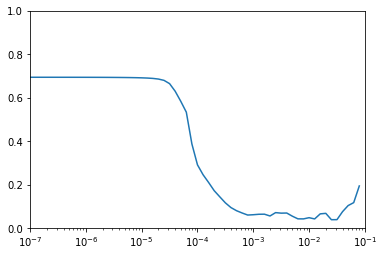

In [26]:
lr_schedule = LearningRateScheduler(lambda epoch: 1e-7 * 10**(epoch / 10))
history_lstm = model3.fit(padded_train, train_labels, epochs=60, callbacks=[lr_schedule],
                          class_weight=class_weight_dict)
plt.semilogx(history_lstm.history["lr"], history_lstm.history["loss"])
plt.axis([1e-7, 1e-1, 0, 1])

Minimum loss is at between 1e-4 to 1e-2, so we can choose 1e-3 as learning rate

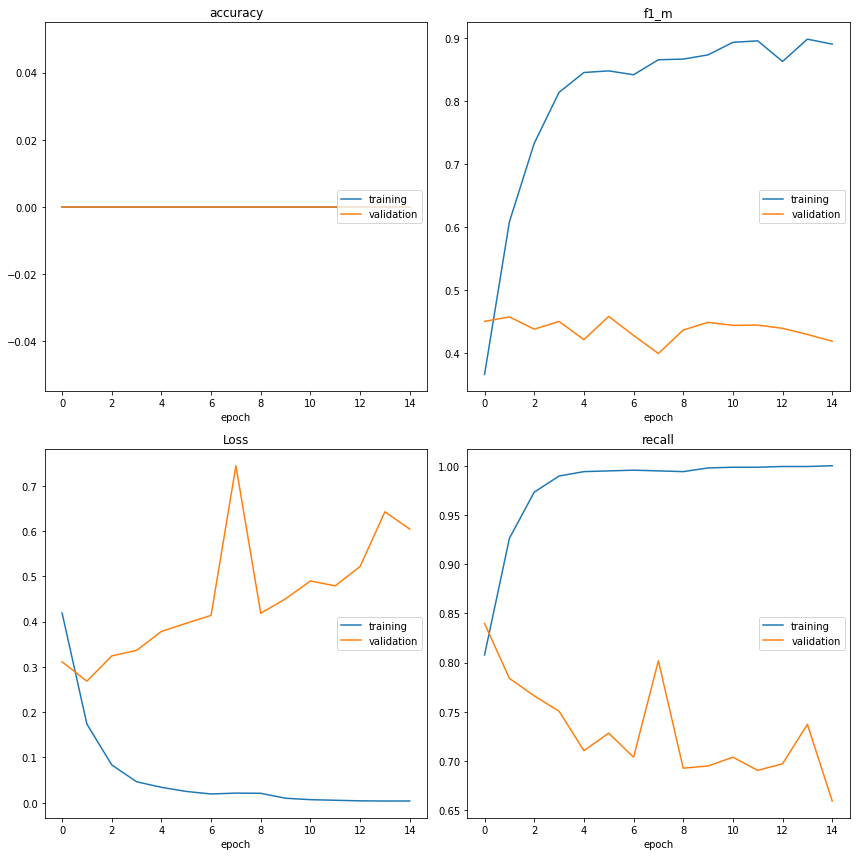

accuracy
	training         	 (min:    0.000, max:    0.000, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
f1_m
	training         	 (min:    0.366, max:    0.899, cur:    0.891)
	validation       	 (min:    0.399, max:    0.458, cur:    0.419)
Loss
	training         	 (min:    0.004, max:    0.419, cur:    0.004)
	validation       	 (min:    0.268, max:    0.744, cur:    0.604)
recall
	training         	 (min:    0.808, max:    1.000, cur:    1.000)
	validation       	 (min:    0.659, max:    0.840, cur:    0.659)


In [27]:
embedding_dim = 8

model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.003
model3.compile(loss='binary_crossentropy',
                                 optimizer=tf.keras.optimizers.Adam(learning_rate),
                                 metrics=[Recall(name='recall'), f1_m, Accuracy()])
model_checkpoint3 = ModelCheckpoint("lstm_checkpoint.h5", save_best_only=True, monitor="val_f1_m", 
                                     mode='max')
model3.fit(padded_train, train_labels, epochs=15, validation_data=(padded_val, val_labels),
           callbacks=[PlotLossesKeras(),model_checkpoint3],class_weight=class_weight_dict)

In [28]:
model31 = load_model('lstm_checkpoint.h5', custom_objects={"f1_m":f1_m})
print("""### Training Scores\n""")
evaluate_model(model31, padded_train, train_labels)
print("""### Validation Scores\n""")
evaluate_model(model31, padded_val, val_labels)

### Training Scores

True positives: 1331, True Negatives: 17708, False Positives: 75, False Negatives: 11 
Accuracy = 0.9955032679738562

F1 Score = 0.9687045123726346

Recall = 0.9918032786885246

Precision = 0.9466571834992887

### Validation Scores

True positives: 327, True Negatives: 5463, False Positives: 473, False Negatives: 122 
Accuracy = 0.9068128425998434

F1 Score = 0.5236188951160928

Recall = 0.7282850779510023

Precision = 0.40875



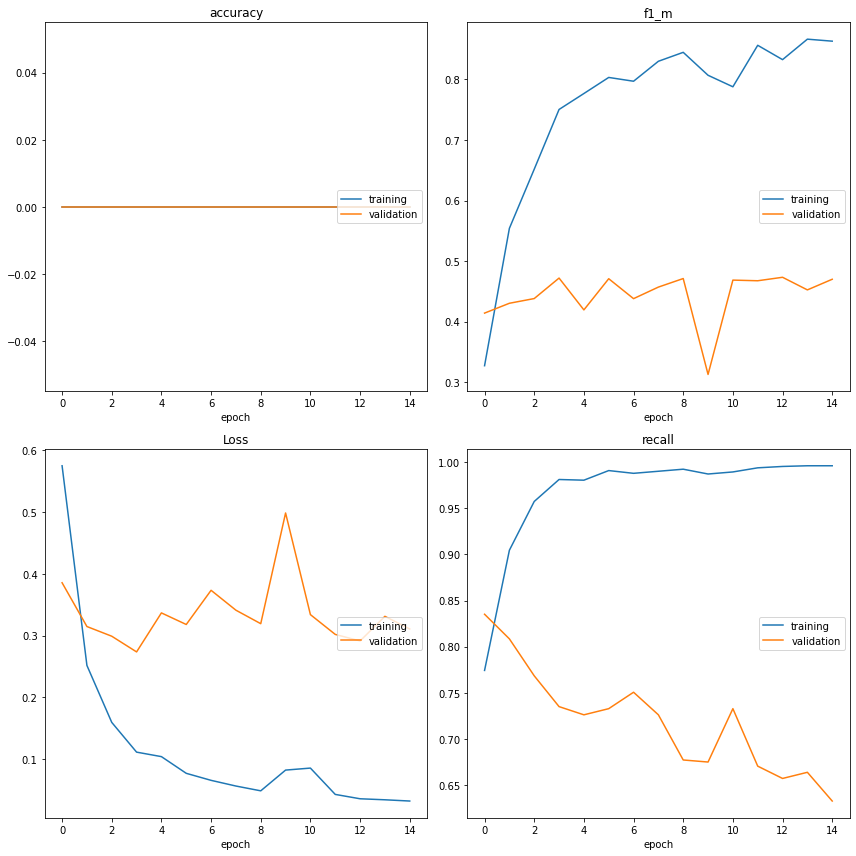

accuracy
	training         	 (min:    0.000, max:    0.000, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
f1_m
	training         	 (min:    0.327, max:    0.866, cur:    0.863)
	validation       	 (min:    0.313, max:    0.473, cur:    0.470)
Loss
	training         	 (min:    0.032, max:    0.575, cur:    0.032)
	validation       	 (min:    0.274, max:    0.499, cur:    0.311)
recall
	training         	 (min:    0.774, max:    0.996, cur:    0.996)
	validation       	 (min:    0.633, max:    0.835, cur:    0.633)


In [29]:
model32 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, kernel_regularizer=regularizers.L1())),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.003
model32.compile(loss='binary_crossentropy',
                                 optimizer=tf.keras.optimizers.Adam(learning_rate),
                                 metrics=[Recall(name='recall'), f1_m, Accuracy()])
model_checkpoint32 = ModelCheckpoint("lstm_checkpoint32.h5", save_best_only=True, monitor="val_f1_m", 
                                     mode='max')
model32.fit(padded_train, train_labels, epochs=15, validation_data=(padded_val, val_labels),
           callbacks=[PlotLossesKeras(),model_checkpoint32],class_weight=class_weight_dict)

In [30]:
model321 = load_model('lstm_checkpoint32.h5', custom_objects={"f1_m":f1_m})
print("""### Training Scores\n""")
evaluate_model(model321, padded_train, train_labels)
print("""### Validation Scores\n""")
evaluate_model(model321, padded_val, val_labels)

### Training Scores

True positives: 1334, True Negatives: 17717, False Positives: 66, False Negatives: 8 
Accuracy = 0.9961307189542483

F1 Score = 0.973012399708242

Recall = 0.9940387481371088

Precision = 0.9528571428571428

### Validation Scores

True positives: 295, True Negatives: 5622, False Positives: 314, False Negatives: 154 
Accuracy = 0.9267032106499609

F1 Score = 0.55765595463138

Recall = 0.6570155902004454

Precision = 0.48440065681444994



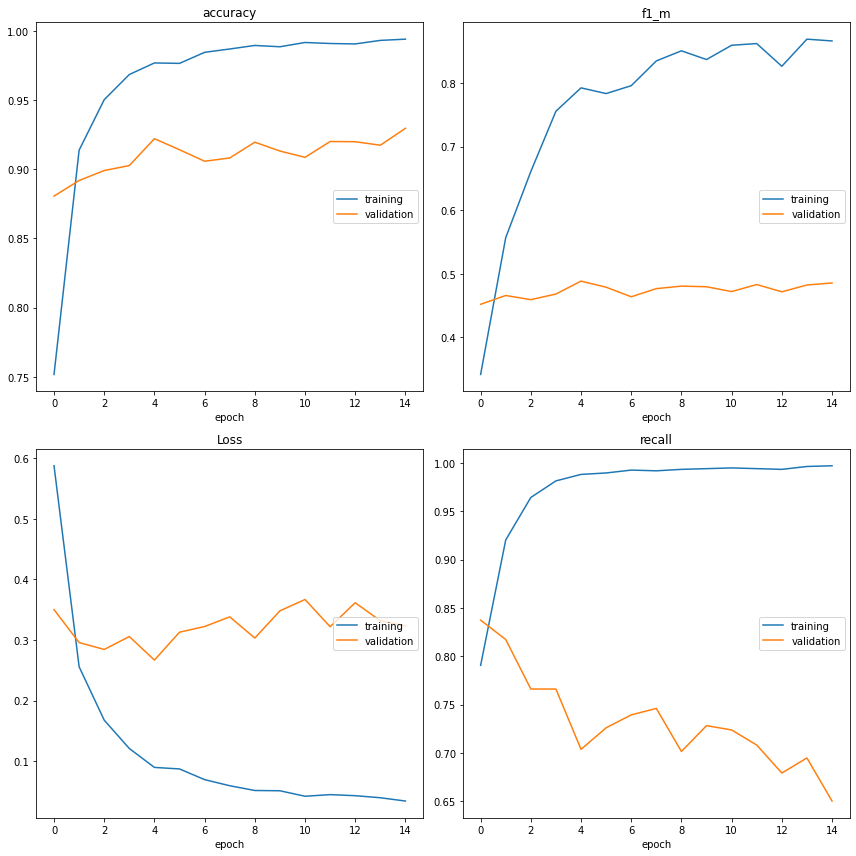

accuracy
	training         	 (min:    0.752, max:    0.994, cur:    0.994)
	validation       	 (min:    0.881, max:    0.930, cur:    0.930)
f1_m
	training         	 (min:    0.342, max:    0.869, cur:    0.866)
	validation       	 (min:    0.452, max:    0.489, cur:    0.486)
Loss
	training         	 (min:    0.034, max:    0.587, cur:    0.034)
	validation       	 (min:    0.267, max:    0.367, cur:    0.323)
recall
	training         	 (min:    0.791, max:    0.997, cur:    0.997)
	validation       	 (min:    0.650, max:    0.837, cur:    0.650)


In [31]:
model33 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, kernel_regularizer=regularizers.L1(), 
                                                       recurrent_regularizer=regularizers.L2())),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.003
model33.compile(loss='binary_crossentropy',
                                 optimizer=tf.keras.optimizers.Adam(learning_rate),
                                 metrics=[Recall(name='recall'), f1_m, 'accuracy'])
model_checkpoint33 = ModelCheckpoint("lstm_checkpoint33.h5", save_best_only=True, monitor="val_f1_m", 
                                     mode='max')
history33 = model33.fit(padded_train, train_labels, epochs=15, validation_data=(padded_val, val_labels),
           callbacks=[PlotLossesKeras(),model_checkpoint33],class_weight=class_weight_dict)

In [32]:
model331 = load_model('lstm_checkpoint33.h5', custom_objects={"f1_m":f1_m})
print("""### Training Scores\n""")
evaluate_model(model331, padded_train, train_labels)
print("""### Validation Scores\n""")
evaluate_model(model331, padded_val, val_labels)

### Training Scores

True positives: 1324, True Negatives: 17624, False Positives: 159, False Negatives: 18 
Accuracy = 0.9907450980392157

F1 Score = 0.9373451327433628

Recall = 0.9865871833084948

Precision = 0.8927848954821308

### Validation Scores

True positives: 316, True Negatives: 5572, False Positives: 364, False Negatives: 133 
Accuracy = 0.9221613155833986

F1 Score = 0.5597874224977857

Recall = 0.7037861915367484

Precision = 0.4647058823529412



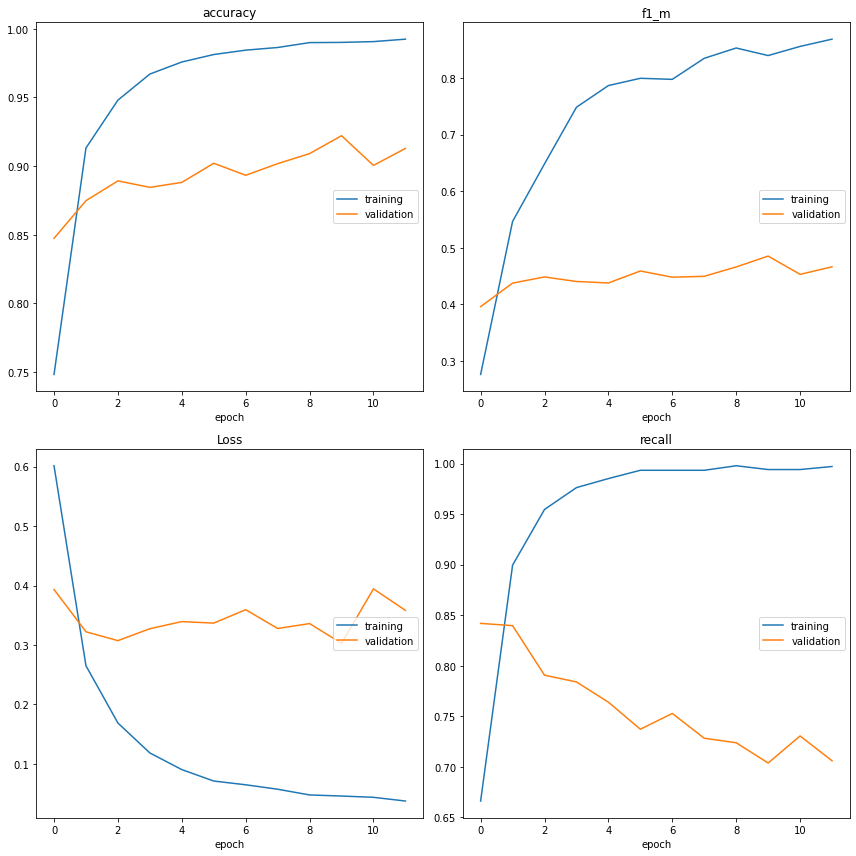

accuracy
	training         	 (min:    0.748, max:    0.992, cur:    0.992)
	validation       	 (min:    0.847, max:    0.922, cur:    0.913)
f1_m
	training         	 (min:    0.277, max:    0.868, cur:    0.868)
	validation       	 (min:    0.396, max:    0.485, cur:    0.466)
Loss
	training         	 (min:    0.037, max:    0.602, cur:    0.037)
	validation       	 (min:    0.303, max:    0.394, cur:    0.358)
recall
	training         	 (min:    0.666, max:    0.998, cur:    0.997)
	validation       	 (min:    0.704, max:    0.842, cur:    0.706)


In [33]:
model34 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 5, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, kernel_regularizer=regularizers.L1(), 
                                                       recurrent_regularizer=regularizers.L2())),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.003
model34.compile(loss='binary_crossentropy',
                                 optimizer=tf.keras.optimizers.Adam(learning_rate),
                                 metrics=[Recall(name='recall'), f1_m, 'accuracy'])
model_checkpoint34 = ModelCheckpoint("lstm_checkpoint34.h5", save_best_only=True, monitor="val_f1_m", 
                                     mode='max')
history34 = model34.fit(padded_train, train_labels, epochs=12, validation_data=(padded_val, val_labels),
           callbacks=[PlotLossesKeras(),model_checkpoint34],class_weight=class_weight_dict)

In [34]:
model341 = load_model('lstm_checkpoint34.h5', custom_objects={"f1_m":f1_m})
print("""### Training Scores\n""")
evaluate_model(model341, padded_train, train_labels)
print("""### Validation Scores\n""")
evaluate_model(model341, padded_val, val_labels)

### Training Scores

True positives: 1315, True Negatives: 17741, False Positives: 42, False Negatives: 27 
Accuracy = 0.9963921568627451

F1 Score = 0.9744349759170062

Recall = 0.9798807749627422

Precision = 0.9690493736182756

### Validation Scores

True positives: 316, True Negatives: 5572, False Positives: 364, False Negatives: 133 
Accuracy = 0.9221613155833986

F1 Score = 0.5597874224977857

Recall = 0.7037861915367484

Precision = 0.4647058823529412



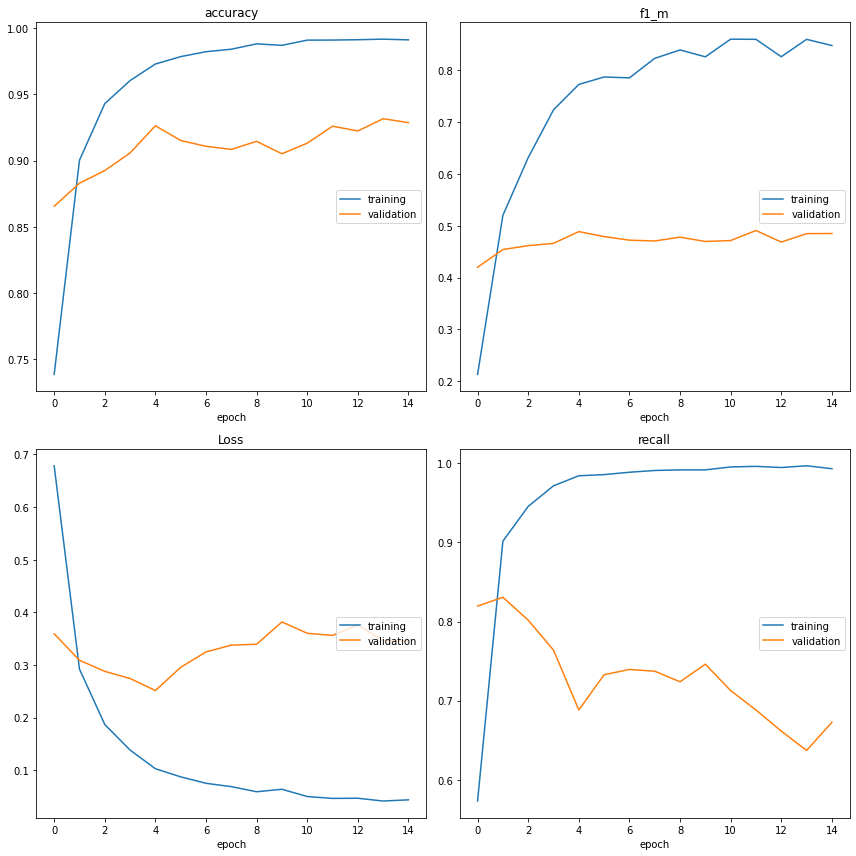

accuracy
	training         	 (min:    0.738, max:    0.992, cur:    0.991)
	validation       	 (min:    0.865, max:    0.932, cur:    0.929)
f1_m
	training         	 (min:    0.213, max:    0.860, cur:    0.848)
	validation       	 (min:    0.420, max:    0.491, cur:    0.485)
Loss
	training         	 (min:    0.042, max:    0.678, cur:    0.044)
	validation       	 (min:    0.252, max:    0.382, cur:    0.346)
recall
	training         	 (min:    0.573, max:    0.997, cur:    0.993)
	validation       	 (min:    0.637, max:    0.831, cur:    0.673)


In [35]:
model35 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, kernel_regularizer=regularizers.L1(), 
                                                       recurrent_regularizer=regularizers.L2())),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.003
model35.compile(loss='binary_crossentropy',
                                 optimizer=tf.keras.optimizers.Adam(learning_rate),
                                 metrics=[Recall(name='recall'), f1_m, 'accuracy'])
model_checkpoint35 = ModelCheckpoint("lstm_checkpoint35.h5", save_best_only=True, monitor="val_f1_m", 
                                     mode='max')
history35 = model35.fit(padded_train, train_labels, epochs=15, validation_data=(padded_val, val_labels),
           callbacks=[PlotLossesKeras(),model_checkpoint35],class_weight=class_weight_dict)

In [36]:
model351 = load_model('lstm_checkpoint35.h5', custom_objects={"f1_m":f1_m})
print("""### Training Scores\n""")
evaluate_model(model351, padded_train, train_labels)
print("""### Validation Scores\n""")
evaluate_model(model351, padded_val, val_labels)

### Training Scores

True positives: 1328, True Negatives: 17751, False Positives: 32, False Negatives: 14 
Accuracy = 0.99759477124183

F1 Score = 0.9829755736491487

Recall = 0.9895678092399404

Precision = 0.9764705882352941

### Validation Scores

True positives: 309, True Negatives: 5603, False Positives: 333, False Negatives: 140 
Accuracy = 0.925920125293657

F1 Score = 0.5664527956003665

Recall = 0.688195991091314

Precision = 0.48130841121495327



Adding regularization improves f1 score but at the cost of lower recall

# Using CNN and LSTM

In [37]:
embedding_dim = 8

model40 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(16,5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 1e-7
model40.compile(loss='binary_crossentropy',
                                 optimizer=tf.keras.optimizers.Adam(learning_rate),
                                 metrics=f1_m)
model40.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 8)             101112    
_________________________________________________________________
conv1d (Conv1D)              (None, 46, 16)            656       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 23, 16)            0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 32)                4224      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 106,025
Trainable params: 106,025
Non-trainable params: 0
_________________________________________________________________


Epoch 1/60
598/598 [==============================] - 11s 7ms/step - loss: 0.6933 - f1_m: 0.0000e+00
Epoch 2/60
598/598 [==============================] - 4s 7ms/step - loss: 0.6933 - f1_m: 0.0000e+00
Epoch 3/60
598/598 [==============================] - 4s 7ms/step - loss: 0.6933 - f1_m: 0.0000e+00
Epoch 4/60
598/598 [==============================] - 4s 7ms/step - loss: 0.6933 - f1_m: 0.0000e+00
Epoch 5/60
598/598 [==============================] - 4s 7ms/step - loss: 0.6933 - f1_m: 0.0000e+00
Epoch 6/60
598/598 [==============================] - 5s 9ms/step - loss: 0.6933 - f1_m: 0.0000e+00
Epoch 7/60
598/598 [==============================] - 5s 8ms/step - loss: 0.6933 - f1_m: 0.0000e+00
Epoch 8/60
598/598 [==============================] - 4s 7ms/step - loss: 0.6933 - f1_m: 0.0000e+00
Epoch 9/60
598/598 [==============================] - 4s 7ms/step - loss: 0.6933 - f1_m: 0.0000e+00
Epoch 10/60
598/598 [==============================] - 4s 7ms/step - loss: 0.6933 - f1_m: 0.0000e+0

(1e-07, 0.1, 0.0, 1.0)

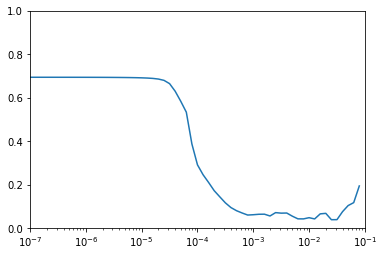

In [38]:
lr_schedule = LearningRateScheduler(lambda epoch: 1e-7 * 10**(epoch / 10))
history_lstm_cnn = model40.fit(padded_train, train_labels, epochs=60, callbacks=[lr_schedule],
                          class_weight=class_weight_dict)
plt.semilogx(history_lstm.history["lr"], history_lstm.history["loss"])
plt.axis([1e-7, 1e-1, 0, 1])

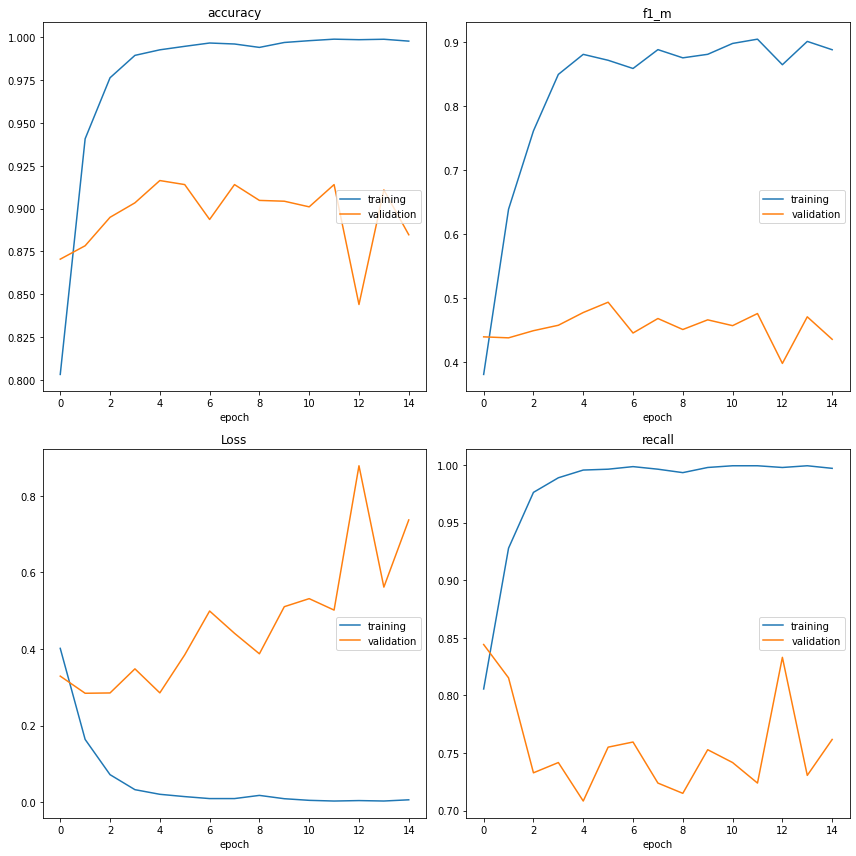

accuracy
	training         	 (min:    0.803, max:    0.999, cur:    0.998)
	validation       	 (min:    0.844, max:    0.916, cur:    0.885)
f1_m
	training         	 (min:    0.381, max:    0.904, cur:    0.888)
	validation       	 (min:    0.398, max:    0.493, cur:    0.436)
Loss
	training         	 (min:    0.003, max:    0.402, cur:    0.006)
	validation       	 (min:    0.284, max:    0.879, cur:    0.737)
recall
	training         	 (min:    0.806, max:    0.999, cur:    0.997)
	validation       	 (min:    0.708, max:    0.844, cur:    0.762)


In [39]:
embedding_dim = 8

model4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(16,5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.004
model4.compile(loss='binary_crossentropy',
                                 optimizer=tf.keras.optimizers.Adam(learning_rate),
                                 metrics=[Recall(name='recall'),f1_m, 'accuracy'])
model4.summary()
model_checkpoint4 = ModelCheckpoint("lstm_cnn_checkpoint4.h5", save_best_only=True, monitor="val_f1_m", 
                                     mode='max')
history_cnn_lstm4 = model4.fit(padded_train, train_labels, epochs=15, validation_data=(padded_val, val_labels),
           callbacks=[PlotLossesKeras(),model_checkpoint4],class_weight=class_weight_dict)

In [40]:
model41 = load_model('lstm_cnn_checkpoint4.h5', custom_objects={"f1_m":f1_m})
print("""### Training Scores\n""")
evaluate_model(model41, padded_train, train_labels)
print("""### Validation Scores\n""")
evaluate_model(model41, padded_val, val_labels)

### Training Scores

True positives: 1341, True Negatives: 17708, False Positives: 75, False Negatives: 1 
Accuracy = 0.9960261437908496

F1 Score = 0.9724437998549674

Recall = 0.9992548435171386

Precision = 0.9470338983050848

### Validation Scores

True positives: 339, True Negatives: 5497, False Positives: 439, False Negatives: 110 
Accuracy = 0.9140172278778387

F1 Score = 0.5525672371638141

Recall = 0.755011135857461

Precision = 0.43573264781491



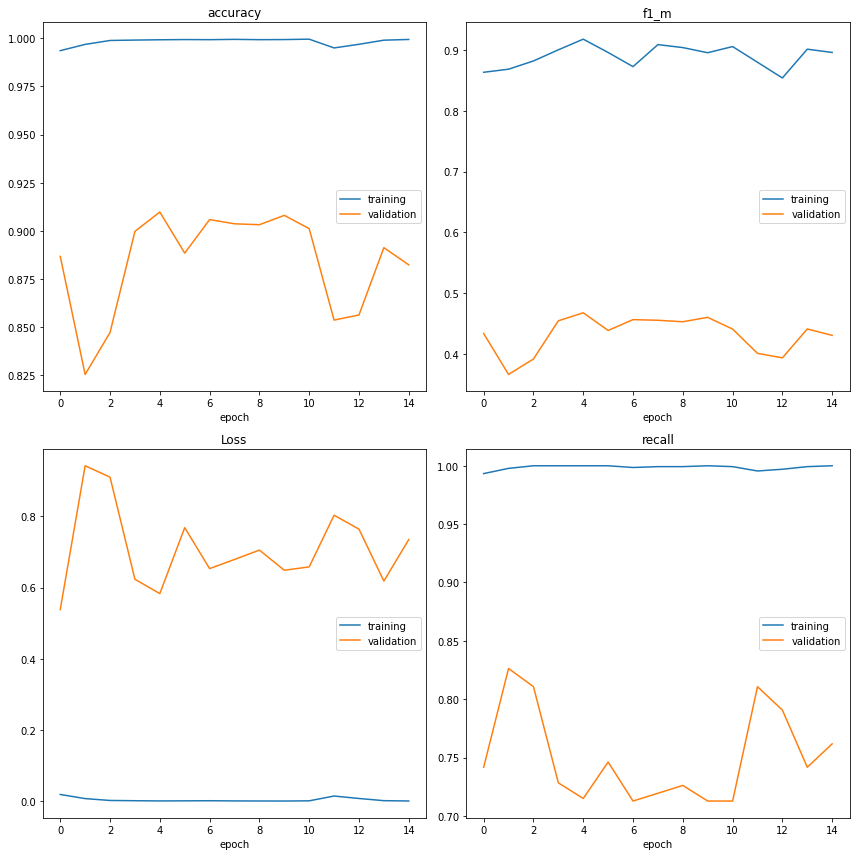

accuracy
	training         	 (min:    0.994, max:    0.999, cur:    0.999)
	validation       	 (min:    0.826, max:    0.910, cur:    0.882)
f1_m
	training         	 (min:    0.854, max:    0.918, cur:    0.896)
	validation       	 (min:    0.366, max:    0.468, cur:    0.431)
Loss
	training         	 (min:    0.001, max:    0.020, cur:    0.001)
	validation       	 (min:    0.539, max:    0.942, cur:    0.735)
recall
	training         	 (min:    0.993, max:    1.000, cur:    1.000)
	validation       	 (min:    0.713, max:    0.826, cur:    0.762)


In [41]:
embedding_dim = 8

model42 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(16,5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, kernel_regularizer=regularizers.L1(), 
                                                       recurrent_regularizer=regularizers.L2())),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.004
model42.compile(loss='binary_crossentropy',
                                 optimizer=tf.keras.optimizers.Adam(learning_rate),
                                 metrics=[Recall(name='recall'),f1_m, 'accuracy'])
model42.summary()
model_checkpoint42 = ModelCheckpoint("lstm_cnn_checkpoint42.h5", save_best_only=True, monitor="val_f1_m", 
                                     mode='max')
history_cnn_lstm42 = model4.fit(padded_train, train_labels, epochs=15, validation_data=(padded_val, val_labels),
           callbacks=[PlotLossesKeras(),model_checkpoint42],class_weight=class_weight_dict)

In [42]:
model421 = load_model('lstm_cnn_checkpoint42.h5', custom_objects={"f1_m":f1_m})
print("""### Training Scores\n""")
evaluate_model(model421, padded_train, train_labels)
print("""### Validation Scores\n""")
evaluate_model(model421, padded_val, val_labels)

### Training Scores

True positives: 1342, True Negatives: 17770, False Positives: 13, False Negatives: 0 
Accuracy = 0.9993202614379085

F1 Score = 0.9951798294401187

Recall = 1.0

Precision = 0.9904059040590406

### Validation Scores

True positives: 321, True Negatives: 5488, False Positives: 448, False Negatives: 128 
Accuracy = 0.909788566953798

F1 Score = 0.5270935960591134

Recall = 0.7149220489977728

Precision = 0.4174252275682705



In [43]:
def create_scores_df(xtest, ytest, models):
    
    model_scores = {"name":[], "recall":[], "precision" : [], "accuracy":[], "f1_score": []}
    for name,model in models:
        model_scores['name'].append(name)
        ypred = np.round(model.predict(xtest))
        model_scores['recall'].append(recall_score(ytest,ypred))
        model_scores['precision'].append(precision_score(ytest,ypred))
        model_scores['accuracy'].append(accuracy_score(ytest,ypred))
        model_scores['f1_score'].append(f1_score(ytest,ypred))

    return pd.DataFrame(model_scores)
    
    

In [44]:
models = [("LSTM 1 - ", model31), 
          ("LSTM 2 - ", model321), 
          ("LSTM 3", model331), 
          ("LSTM 4", model341), 
          ("LSTM 5", model351), 
          ("CNN_LSTM ", model41), 
          ("CNN_LSTM2", model421)]

In [45]:
scores_df = create_scores_df(padded_test, test_labels, models)
scores_df

,name,recall,precision,accuracy,f1_score
0,LSTM 1 -,0.743304,0.409594,0.906784,0.528152
1,LSTM 2 -,0.696429,0.488263,0.927464,0.574057
2,LSTM 3,0.736607,0.466102,0.922294,0.570934
3,LSTM 4,0.705357,0.460641,0.921354,0.557319
4,LSTM 5,0.705357,0.487654,0.927307,0.576642
5,CNN_LSTM,0.756696,0.419554,0.909447,0.539809
6,CNN_LSTM2,0.712054,0.414286,0.909134,0.523810


In [46]:
logregscore = create_scores_df(X_test_tfidf, y_test, [("Base model", logReg1)])

In [47]:
scores_df = pd.concat([scores_df, logregscore], axis=0)

In [48]:
scores_df

,name,recall,precision,accuracy,f1_score
0,LSTM 1 -,0.743304,0.409594,0.906784,0.528152
1,LSTM 2 -,0.696429,0.488263,0.927464,0.574057
2,LSTM 3,0.736607,0.466102,0.922294,0.570934
3,LSTM 4,0.705357,0.460641,0.921354,0.557319
4,LSTM 5,0.705357,0.487654,0.927307,0.576642
5,CNN_LSTM,0.756696,0.419554,0.909447,0.539809
6,CNN_LSTM2,0.712054,0.414286,0.909134,0.523810
0,Base model,0.725446,0.484352,0.926524,0.580876
